In [16]:
%reload_ext autoreload
%autoreload 2

import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn.cluster import KMeans
import statsmodels.api as sm
from lib import utils


mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = 16

In [17]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)

In [18]:
# If data is clustered to three groups, one of these groups only has 9 subjects
# This explains why we only cluster subjects to two groups 
df_time_pivot_2 = df.pivot(index='worker_id', columns='reward', values='value_surplus')
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(df_time_pivot_2.values)
print('Number of participants in each cluster:',np.bincount(kmeans.labels_))

Number of participants in each cluster: [105  43   9]


c:\users\PHD19ZW1\Appdata\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
# Spearman rank-order correlation
# the entire sample
print(stats.spearmanr(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.spearmanr(df[df['label_kmeans'] == 0]['value_surplus'],
                df[df['label_kmeans'] == 0]['front_amount']))

# cluster 2
print(stats.spearmanr(df[df['label_kmeans'] == 1]['value_surplus'],
                    df[df['label_kmeans'] == 1]['front_amount']))

SignificanceResult(statistic=-0.043245998593847375, pvalue=0.04263276342226129)
SignificanceResult(statistic=-0.17557494143900643, pvalue=1.189944758721708e-06)
SignificanceResult(statistic=-0.016437572770570754, pvalue=0.5328273275241426)


In [20]:
df['front_amount_6m'] = df['front_amount'] * (df['seq_length'] == '6 months')
df['front_amount_12m'] = df['front_amount'] * (df['seq_length'] == '12 months')
df['front_amount_6m_0'] = df['front_amount_6m']  * (df['label_kmeans'] == 0)
df['front_amount_6m_1'] = df['front_amount_6m']  * (df['label_kmeans'] == 1)
df['front_amount_12m_0'] = df['front_amount_12m']  * (df['label_kmeans'] == 0)
df['front_amount_12m_1'] = df['front_amount_12m']  * (df['label_kmeans'] == 1)


df_dummy = pd.concat([df,pd.get_dummies(df['worker_id'], prefix='worker_id')],axis=1)
df_filtered = utils.rule_out_outlier(df_dummy,col_name='value_surplus')

reg_cols_baseline = ['front_amount_6m','front_amount_12m','choice_peli']
reg_cols_label = ['front_amount_6m_0','front_amount_12m_0','front_amount_6m_1','front_amount_12m_1','choice_peli']
reg_cols_dummy = reg_cols_baseline + [col for col in df_dummy.columns if col.startswith('worker_id_')]
reg_cols_dummy_2 = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]


formula_pool_1 = 'value_surplus ~ front_amount_6m + front_amount_12m + choice_peli'
model_ols_pool_1 = sm.OLS.from_formula(formula_pool_1,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

Number of outliers (lower and upper): [4, 8]


In [21]:
formula_pool_2 = 'value_surplus ~ front_amount_6m_0 + front_amount_12m_0 + front_amount_6m_1 + front_amount_12m_1 + choice_peli'
model_ols_pool_2 = sm.OLS.from_formula(formula_pool_2,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

In [22]:
formula_fe = formula_pool_1 + '+C(worker_id)'
model_ols_fe = sm.OLS.from_formula(formula_fe,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

pd.concat([model_ols_fe.params[reg_cols_baseline].rename('coef'),
           model_ols_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_ols_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.005040,0.014359,-0.009075,-0.001005
front_amount_12m,-0.005306,0.009632,-0.009324,-0.001289
choice_peli,9.186859,0.000000,9.158254,9.215465


In [23]:
formula_fe_2 = formula_pool_2 + '+C(worker_id)'
model_ols_fe_2 = sm.OLS.from_formula(formula_fe_2,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

pd.concat([model_ols_fe_2.params[reg_cols_label].rename('coef'),
           model_ols_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_ols_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,-0.018557,1.090818e-05,-0.026827,-0.010288
front_amount_12m_0,-0.020008,7.519102e-07,-0.027934,-0.012082
front_amount_6m_1,0.002069,2.614515e-01,-0.001542,0.005681
front_amount_12m_1,0.002432,1.914368e-01,-0.001217,0.006082
choice_peli,7.278428,1.284148e-91,6.575698,7.981157


In [24]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_baseline]).astype(float)
model_rlm_pool_1 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale(),cov='H2')
model_rlm_pool_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2198
Model:                                                                            RLM   Df Residuals:                     2194
Method:                                                                          IRLS   Df Model:                            3
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000001CD092C0820>                                         
Cov Type:                                                                          H2                                         
Date:                                                                Mon, 05 Feb 2024                                         
Time:                                                                        15:41:39                                         
No. Iterations:                                                                    12                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               55.0002      0.987     55.735      0.000      53.066      56.934
front_amount_6m     -0.0048      0.002     -1.938      0.053      -0.010    5.55e-05
front_amount_12m    -0.0060      0.003     -2.396      0.017      -0.011      -0.001
choice_peli         -0.8484      0.891     -0.952      0.341      -2.595       0.898
====================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [25]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_label]).astype(float)
model_rlm_pool_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale(),cov='H2')
model_rlm_pool_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2198
Model:                                                                            RLM   Df Residuals:                     2192
Method:                                                                          IRLS   Df Model:                            5
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000001CD04E4FE20>                                         
Cov Type:                                                                          H2                                         
Date:                                                                Mon, 05 Feb 2024                                         
Time:                                                                        15:41:39                                         
No. Iterations:                                                                    20                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 55.5403      0.760     73.076      0.000      54.051      57.030
front_amount_6m_0     -0.0590      0.003    -19.339      0.000      -0.065      -0.053
front_amount_12m_0    -0.0643      0.003    -21.967      0.000      -0.070      -0.059
front_amount_6m_1      0.0155      0.002      7.603      0.000       0.011       0.019
front_amount_12m_1     0.0152      0.002      7.457      0.000       0.011       0.019
choice_peli           -0.6821      0.677     -1.007      0.314      -2.010       0.645
======================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [26]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)
model_rlm_fe = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale(),cov='H2')

pd.concat([model_rlm_fe.params[reg_cols_baseline].rename('coef'),
           model_rlm_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_rlm_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.004768,1.299708e-06,-0.006699,-0.002837
front_amount_12m,-0.006412,9.138827e-11,-0.008351,-0.004473
choice_peli,2.181327,NaN,NaN,NaN


In [27]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy_2]).astype(float)
model_rlm_fe_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale(),cov='H2')

pd.concat([model_rlm_fe_2.params[reg_cols_label].rename('coef'),
           model_rlm_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_rlm_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,-0.016540,1.766165e-20,-0.020034,-0.013045
front_amount_12m_0,-0.021410,3.415874e-33,-0.024906,-0.017914
front_amount_6m_1,0.000059,9.587551e-01,-0.002165,0.002283
front_amount_12m_1,-0.000203,8.590688e-01,-0.002443,0.002037
choice_peli,2.279011,NaN,NaN,NaN


NormaltestResult(statistic=1407.782552565554, pvalue=2.0132738404586662e-306)


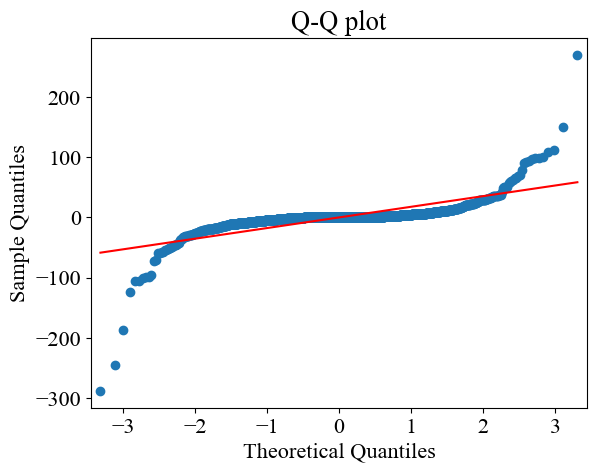

In [28]:
pplot = sm.ProbPlot(model_rlm_fe_2.resid)
fig = pplot.qqplot(line='s')
plt.title('Q-Q plot')
print(stats.normaltest(model_rlm_fe_2.resid))

In [29]:
# save regression results
model_results = {'ols_pool_baseline':utils.get_reg_result(model_ols_pool_1,reg_cols_baseline),
                 'ols_pool_label':utils.get_reg_result(model_ols_pool_2,reg_cols_label),
                 'ols_fe_baseline':utils.get_reg_result(model_ols_fe,reg_cols_baseline),
                 'ols_fe_label':utils.get_reg_result(model_ols_fe_2,reg_cols_label),
                 'rlm_pool_baseline':utils.get_reg_result(model_rlm_pool_1,reg_cols_baseline),
                 'rlm_pool_label':utils.get_reg_result(model_rlm_pool_2,reg_cols_label),
                 'rlm_fe_baseline':utils.get_reg_result(model_rlm_fe,reg_cols_baseline),
                 'rlm_fe_label':utils.get_reg_result(model_rlm_fe_2,reg_cols_label)
                 }

with open('model_reg_result_k.json', "w") as f:
    json.dump(model_results, f)

In [30]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_1,param_names=reg_cols_baseline,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_baseline_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:22<00:00, 43.91it/s]


In [31]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_2,param_names=reg_cols_label,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_label_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:26<00:00, 37.91it/s]


In [32]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe,param_names=reg_cols_baseline,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_baseline_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [32:15<00:00,  1.94s/it]


In [33]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe_2,param_names=reg_cols_label,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_label_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [33:12<00:00,  1.99s/it]
